## Maxwell A. Fine 2024-08-25

This notebook is for opening a `.fil` file that we know has an FRB (that I detected!). The detection pipeline failed as the file had too much RFI, but we know its threre because Omar at Wb made a postive detection. 

I tried this before but could not do this, I tried `candidate_maker.py`. Thankfully Omar was able to inspect our `.fil` file. Here I try to replicate what he did. 



Notes:

- Install sigpyproc with `pip install git+https://github.com/telegraphic/sigpyproc`
### Outline of Tasks:
- read in `.fil` file
- slice 3 seond chunk into numpy like arrays around burst
- create python function to dedisperse the data
    - Move each freq row over n cells to account for the arrival time delay 

- cut out noisy freq channels 
- apply bandpass correction
- adjust plotting vmin, vmax

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import sigpyproc.Readers as readers


# we are only looking at the L1-band for now
data_file = '/home/afinemax/afinemax/khazad-dum/research/astron_2024/FRB20240619D_L1_Band_2024_08_15_23_09_03.fil'


In [2]:
def read_fil_file(file_path):
    '''# function to read in data, header from a .fil file
    returns data, header'''

    # Open the .fil file using sigpyproc
    fil_file = readers.FilReader(file_path)
    
    # Read the header information
    header = fil_file.header
    
    # Read the data (e.g., get_block can be used to read specific chunks)
    # Here, we'll read the entire file into a numpy array.
    data = fil_file.readBlock(0, fil_file.header.nsamples)
    
    return data, header

In [3]:
# function to slice data

def slice_fil(data, header, time_since_t0, dt):
    """
    Slices a chunk of the filterbank data centered around a specified time.

    Parameters:
    data : numpy.ndarray
        The filterbank data array with shape (n_channels, n_samples).
    header : dict
        The header dictionary containing metadata about the filterbank file.
    time_since_t0 : float
        The time (in seconds) since the start of the observation to center the slice around.
    dt : float
        The duration (in seconds) of the slice.

    Returns:
    numpy.ndarray
        A sliced chunk of the filterbank data centered around `time_since_t0` with duration `dt`.
        Returns None if slicing fails due to invalid indices.
    """
    try:
        # Sampling time in seconds and total number of samples
        tsamp = header['tsamp']  # in seconds
        nsamples = header['nsamples']

        # Convert time_since_t0 and dt to sample indices
        start_i = int((time_since_t0 - 0.5 * dt) / tsamp)
        end_i = int((time_since_t0 + 0.5 * dt) / tsamp)

        # Check if the calculated indices are within the valid range
        if start_i >= 0 and end_i <= nsamples:
            # Slice the data array: keeping all frequency channels and slicing the time axis
            sliced_data = data[:, start_i:end_i]
            return sliced_data
        else:
            print("Error in slicing: the candidate is out of the range of the file. "
                  "Ensure that `time_since_t0` is in seconds since the start of the file.")
            return None

    except Exception as e:
        print(f"An error occurred during slicing: {e}")
        return None


In [4]:
data, header = read_fil_file(data_file)


# print(header)
# lets read off some import stuff from the header 

source_name = header['source_name']
nchans = header['nchans']
fch1 = header['fch1'] # freqency of the top channel
foff = header['foff'] # not sure
tsart = header['tstart'] # in mjd 
nsamples = header['nsamples']
ftop = header['ftop'] # in MHz
fbottom = header['fbottom'] # in Mhz
tsamp = header['tsamp'] # in


# tcand is ~ 106.3 seconds from the start of the file 


# Calculate the frequency for each channel
frequencies = fch1 + np.arange(nchans) * foff
frequencies_inverted = frequencies[::-1]

# Time axis in seconds
time_samples = np.arange(data.shape[1]) * tsamp + tsart  # Add start time to each sample



# Create a mask for frequencies between 1215 MHz and 1265 MHz

# Apply the mask to set values in the specified frequency range to NaN
#data[mask, :] = np.nan

# new time axis

time_since_t0 = 106.3
dt = 1.5
start_time = time_since_t0 - 0.5 * dt
end_time = time_since_t0 + 0.5 * dt
time_samples = np.linspace(start_time, end_time, data.shape[1])



time_since_t0 = 106.4
dt = 1.5

data = slice_fil(data, header, time_since_t0, dt)

mask = (frequencies >= 1215) & (frequencies <= 1265)


In [5]:
header

{'machine_id': 0,
 'telescope_id': 8,
 'data_type': 1,
 'ibeam': 1,
 'source_name': 'FRB20240619D',
 'nchans': 320,
 'nbeams': 1,
 'nbits': 32,
 'nifs': 1,
 'fch1': 1300.0,
 'foff': -0.3125,
 'tstart': 60537.88129629678,
 'tsamp': 0.0001984,
 'src_raj': 194928.7974480401,
 'src_dej': -251234.20292093366,
 'az_start': -8.609945222421313,
 'za_start': 78.48328933758769,
 'hdrlen': 327,
 'filelen': 3870967367,
 'nbytes': 3870967040,
 'nsamples': 3024193,
 'filename': '/home/afinemax/afinemax/khazad-dum/research/astron_2024/FRB20240619D_L1_Band_2024_08_15_23_09_03.fil',
 'basename': '/home/afinemax/afinemax/khazad-dum/research/astron_2024/FRB20240619D_L1_Band_2024_08_15_23_09_03',
 'extension': '.fil',
 'bandwidth': 100.0,
 'ftop': 1300.15625,
 'fbottom': 1200.15625,
 'fcenter': 1250.15625,
 'tobs': 599.9998912,
 'ra': '19:49:28.7974',
 'dec': '-25:12:34.2029',
 'ra_rad': 5.190085407578201,
 'dec_rad': -0.4399887918411073,
 'ra_deg': 297.3699891666666,
 'dec_deg': -25.209500805555557,
 'ob

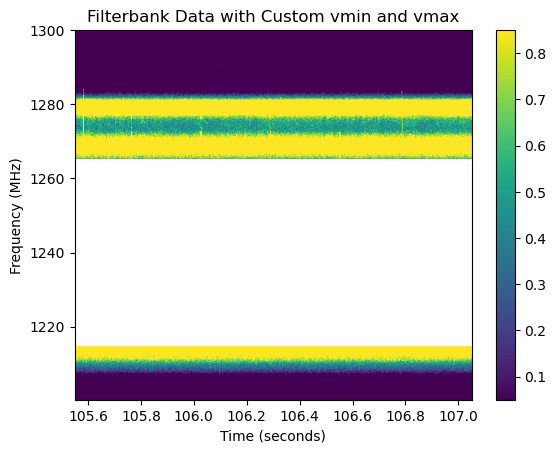

In [6]:
# Plotting

plotting_data = data
plotting_data[mask, : ] = np.nan
plotting_data = (plotting_data - np.nanmean(data) ) / np.nanstd(data)


plt.imshow(plotting_data, aspect='auto', vmin=0.05, vmax=0.85, extent=[time_samples.min(), time_samples.max(), frequencies_inverted.min(), frequencies_inverted.max()])
plt.colorbar()  # Show a colorbar to see the color mapping
plt.xlabel('Time (seconds)')  # Label the x-axis
plt.ylabel('Frequency (MHz)')  # Label the y-axis
plt.title('Filterbank Data with Custom vmin and vmax')
plt.show()

In [7]:
foff

-0.3125

In [8]:
import numpy as np

def delta_t(DM, freq1, freq2, constant=4.149e-3):
    """
    Calculates the time delay between two frequencies due to dispersion.

    Parameters:
    DM (float): Dispersion measure in pc/cm^3.
    freq1 (float): First frequency in GHz.
    freq2 (float): Second frequency in GHz.
    constant (float, optional): Constant used in the dispersion formula, defaults to 4.149e-3

    Returns:
    float: Arrival Time delay in seconds between the freq1 and freq2.
    """
    return constant * DM * ((1 / freq1) ** 2 - (1 / freq2) ** 2)

def dedisperse(data, header, DM):
    """
    Dedisperses the filterbank data for a given DM.

    Parameters:
    data (numpy.ndarray): 2D array of the filterbank data (n_channels, n_samples).
    header (dict): Header dictionary containing metadata about the filterbank file.
    DM (float): Dispersion measure in pc/cm^3.

    Returns:
    numpy.ndarray: Dedispersed data.
    """
    nchans = header['nchans']
    fch1 = header['fch1']  # Frequency of the top channel in MHz
    foff = header['foff']  # Frequency offset in MHz
    tsamp = header['tsamp']  # Sample time in seconds

    # Calculate frequency values for each channel in MHz
    frequencies = fch1 + np.arange(nchans) * foff

    # Convert frequencies from MHz to GHz for delta_t calculation
    frequencies_ghz = frequencies / 1000.0
    ftop_ghz = frequencies_ghz[0]

    # Calculate the time delays for each frequency relative to the top frequency
    delays = np.array([delta_t(DM, freq, ftop_ghz) for freq in frequencies_ghz])

    # Convert delays from seconds to sample indices
    delay_samples = np.round(delays / tsamp).astype(int)

    # Create an empty array with NaNs to store dedispersed data
    dedispersed_data = np.full_like(data, np.nan)

    # Fill in the dedispersed data
    for i in range(nchans):
        # Calculate the source and destination indices
        source_indices = np.arange(data.shape[1])
        
        # We subtract the delay to align all the arrival times
        dest_indices = source_indices - delay_samples[i]

        # Ensure destination indices are within bounds
        valid_indices = (dest_indices >= 0) & (dest_indices < data.shape[1])
        dedispersed_data[i, dest_indices[valid_indices]] = data[i, source_indices[valid_indices]]

    return dedispersed_data


In [34]:
import numpy as np

def bandpass_correct(data, exclude_brightest=True):
    """
    Applies a bandpass correction to the data by normalizing each frequency channel.
    
    Parameters:
    data (numpy.ndarray): 2D array of the filterbank data (n_channels, n_samples).
    exclude_brightest (bool): If True, the mean and standard deviation are calculated 
                              excluding the brightest 10% of the data.

    Returns:
    numpy.ndarray: Bandpass-corrected data.
    """
    corrected_data = np.full_like(data, np.nan)
    
    # Iterate over each frequency channel
    for i in range(data.shape[0]):
        channel_data = data[i, :]
        
        if exclude_brightest:
            # Filter out NaNs before calculating the threshold
            non_nan_data = channel_data[~np.isnan(channel_data)]
            
            # Check if non_nan_data is not empty
            if non_nan_data.size == 0:
                continue  # Skip processing this channel if it's empty

            threshold = np.percentile(non_nan_data, 95)
            filtered_data = channel_data[channel_data <= threshold]
        else:
            filtered_data = channel_data
        
        # Check if filtered_data is not empty
        if filtered_data.size == 0:
            continue  # Skip processing this channel if it's empty
        
        mean = np.nanmean(filtered_data)
        std = np.nanstd(filtered_data)
        
        # Avoid division by zero
        if std > 0:
            corrected_data[i, :] = (channel_data - mean) / std
        else:
            corrected_data[i, :] = channel_data - mean  # No division if std is 0
    
    return corrected_data


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(106.3, 106.4)

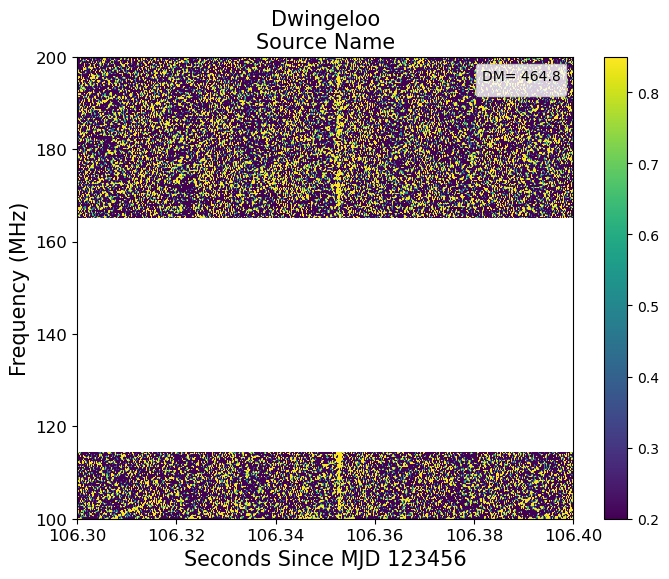

In [47]:
DM = 464.8
dedispersed_data = dedisperse(data, header, DM)

start_time = time_since_t0 - 0.5 * dt
end_time = time_since_t0 + 0.5 * dt
time_samples = np.linspace(start_time, end_time, data.shape[1])




# Apply bandpass correction
mask = (frequencies >= 1215) & (frequencies <= 1265)
#dedispersed_data[mask] = np.nan
bandpass_corrected_data = bandpass_correct(dedispersed_data)

plotting_data = bandpass_corrected_data

plt.figure(figsize=(8,6))
plt.imshow(plotting_data, aspect='auto', vmin=0.20, vmax=0.85, extent=[time_samples.min(), time_samples.max(), frequencies_inverted.min(), frequencies_inverted.max()])
plt.colorbar()  # Show a colorbar to see the color mapping
plt.xlabel(f'Seconds Since MJD {tsart}', size=15)  # Label the x-axis
plt.ylabel('Frequency (MHz)', size=15)  # Label the y-axis
plt.title(f'Dwingeloo\n{source_name}', size=15)

plt.legend(title=f'DM= {DM}')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(106.3, 106.4)



plotting_data shape: (320, 7560)
time_samples length: 7560


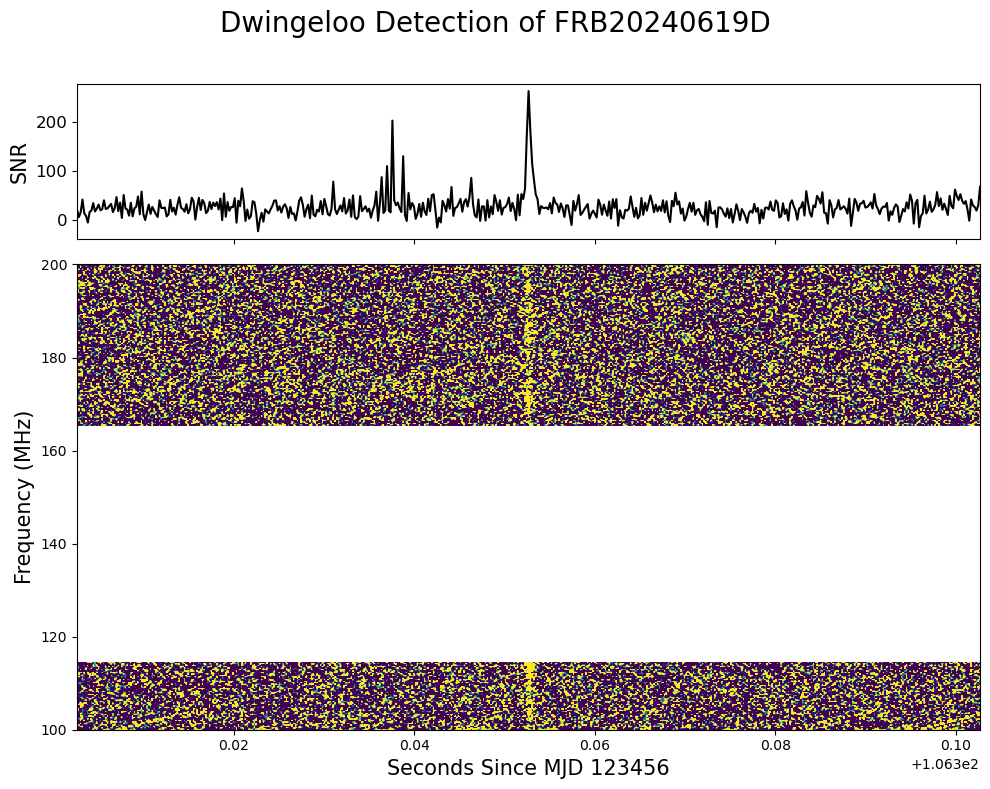

In [52]:
import numpy as np
import matplotlib.pyplot as plt


source_name = 'FRB20240619D'
# Check the shape of plotting_data and time_samples
print(f'plotting_data shape: {plotting_data.shape}')
print(f'time_samples length: {len(time_samples)}')

# Sum all the frequency channels to get the time-series data
time_series_data = np.nansum(plotting_data, axis=0) 

# Ensure the dimensions match
assert len(time_series_data) == len(time_samples), "Mismatch in dimensions!"

# Find the peak index and peak time
peak_index = np.argmax(time_series_data)
peak_time = time_samples[peak_index]

# Define the time range for plotting around the peak
dt_plotting = 0.1  # seconds
xlim_min = peak_time - 0.5 * dt_plotting
xlim_max = peak_time + 0.5 * dt_plotting

# Create a figure with 2 subplots, one above the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)

# Plot the time-series on the first subplot (ax1) centered around the peak time
ax1.plot(time_samples, time_series_data, color='black')
ax1.set_xlim(xlim_min, xlim_max)
ax1.set_ylabel('SNR', size=15)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Plot the dynamic spectra on the second subplot (ax2) with the updated x-axis range
im = ax2.imshow(plotting_data, aspect='auto', vmin=0.20, vmax=0.85,
                extent=[time_samples.min(), time_samples.max(),
                        frequencies_inverted.min(), frequencies_inverted.max()])
# plt.colorbar(im, ax=ax2)  # Show a colorbar on the dynamic spectra if needed
ax2.set_xlabel(f'Seconds Since MJD {tsart}', size=15)  # Label the x-axis
ax2.set_ylabel('Frequency (MHz)', size=15)  # Label 

# Update x-axis extent for ax2 to match the centered range around the peak time
ax2.set_xlim(xlim_min, xlim_max)

plt.suptitle(f'Dwingeloo Detection of {source_name}', size=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust spacing to prevent overlap with the suptitle

plt.savefig('FRB20240619D_drt_maxfine_2014-08-17.png', dpi=300, bbox_inches='tight')

plt.show()

plotting_data shape: (320, 7560)
time_samples length: 7560


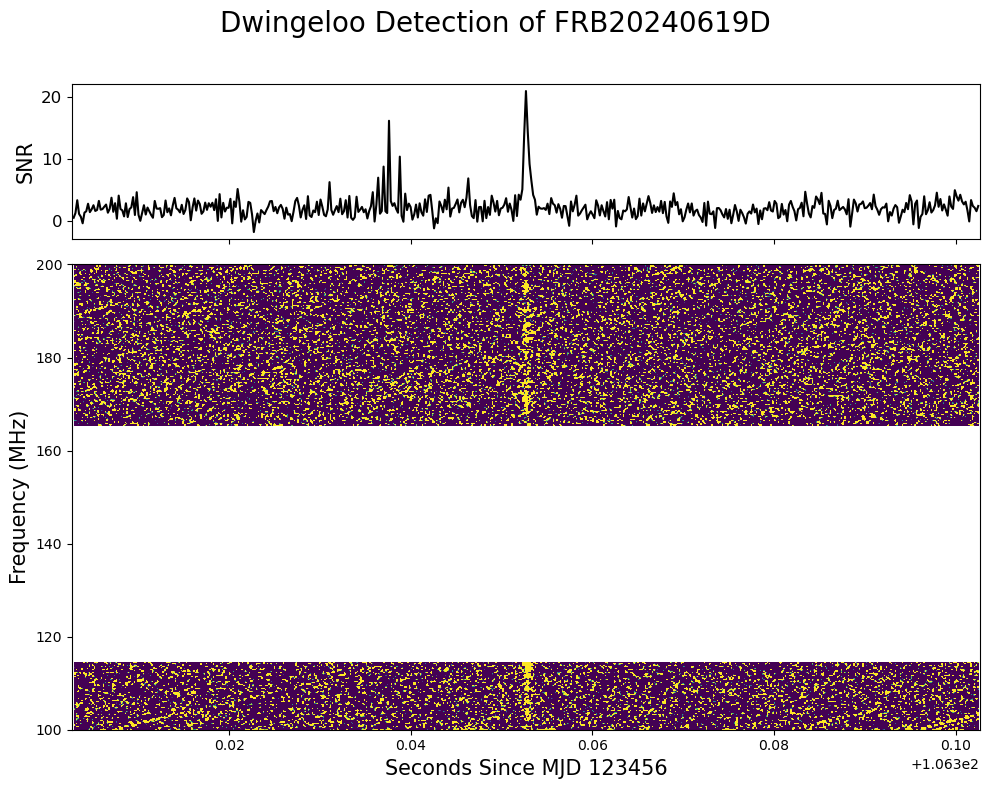

In [76]:
import numpy as np
import matplotlib.pyplot as plt

source_name = 'FRB20240619D'
# Check the shape of plotting_data and time_samples
print(f'plotting_data shape: {plotting_data.shape}')
print(f'time_samples length: {len(time_samples)}')

# Sum all the frequency channels to get the time-series data
time_series_data = np.nansum(plotting_data, axis=0) 

# Ensure the dimensions match
assert len(time_series_data) == len(time_samples), "Mismatch in dimensions!"

# Find the peak index and peak time
peak_index = np.argmax(time_series_data)
peak_time = time_samples[peak_index]

# Define the time range for plotting around the peak
dt_plotting = 0.1  # seconds
xlim_min = peak_time - 0.5 * dt_plotting
xlim_max = peak_time + 0.5 * dt_plotting

# Find the indices within the desired time range
time_indices = (time_samples >= xlim_min) & (time_samples <= xlim_max)

# Slice the data
time_samples_sliced = time_samples[time_indices]
time_series_data_sliced = time_series_data[time_indices]
plotting_data_sliced = plotting_data[:, time_indices]

# Create a figure with 2 subplots, one above the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)

# Plot the time-series on the first subplot (ax1) centered around the peak time
ax1.plot(time_samples_sliced, time_series_data_sliced*np.sqrt(159) / 159, color='black')
ax1.set_xlim(xlim_min, xlim_max)
ax1.set_ylabel('SNR', size=15)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Plot the dynamic spectra on the second subplot (ax2) with the updated x-axis range
im = ax2.imshow(plotting_data_sliced, aspect='auto', vmin=0.80, vmax=0.99,
                extent=[time_samples_sliced.min(), time_samples_sliced.max(),
                        frequencies_inverted.min(), frequencies_inverted.max()])
# plt.colorbar(im, ax=ax2)  # Show a colorbar on the dynamic spectra if needed
ax2.set_xlabel(f'Seconds Since MJD {tsart}', size=15)  # Label the x-axis
ax2.set_ylabel('Frequency (MHz)', size=15)  # Label 

# Update x-axis extent for ax2 to match the centered range around the peak time
ax2.set_xlim(xlim_min, xlim_max)

plt.suptitle(f'Dwingeloo Detection of {source_name}', size=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust spacing to prevent overlap with the suptitle

plt.savefig('FRB20240619D_drt_maxfine_2014-08-17.png', dpi=300, bbox_inches='tight')

plt.show()


In [64]:
np.shape(plotting_data_sliced)

(320, 503)

In [65]:
import numpy as np

# Assuming plotting_data_sliced is your data array with shape (320, 503)

# Create a boolean mask where True indicates NaN values
nan_mask = np.isnan(plotting_data_sliced)

# Count non-NaN values in each row (axis=1)
non_nan_counts = np.sum(~nan_mask, axis=1)

# Print the number of non-NaN values for each of the 320 rows
print(non_nan_counts)


[503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503
 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503
 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503
 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503
 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503
 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503 503
 503 503 503 503   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [68]:
np.sum(np.asarray(non_nan_counts)) / 503

159.0